# Importing Data

In [3]:
import numpy as np
import pandas as pd 
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten
from keras.optimizers import RMSprop,SGD, Adam
from keras import regularizers
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from keras.utils import plot_model

# Ploting Images

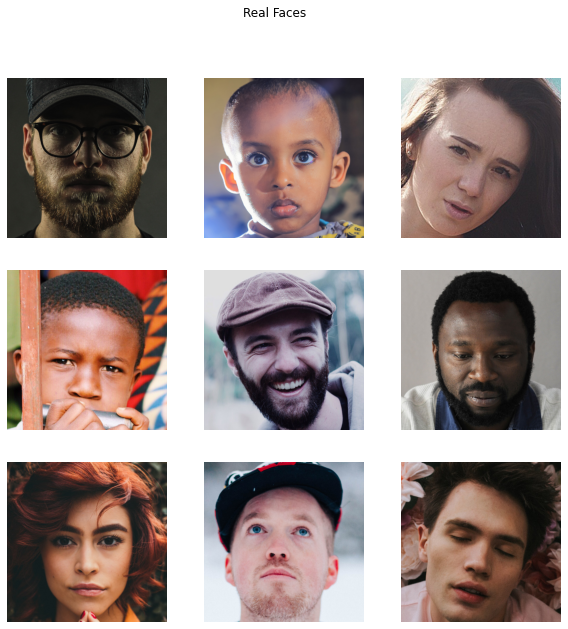

In [4]:
train_fake = '../input/real-and-fake-face-detection/real_and_fake_face/training_fake/'
train_real = '../input/real-and-fake-face-detection/real_and_fake_face/training_real/'

def plot_image(path, title):
    plt.figure(figsize=(10,10))
    for i in range(9):
        img = load_img(path +'/' +os.listdir(path)[i])
        plt.subplot(3,3,i+1)
        plt.imshow(img)
        if title=='Fake Faces':
            plt.title(os.listdir(path)[i][:4])
        plt.suptitle(title)
        plt.axis('off')
    return plt
plot_image(train_real, 'Real Faces').show()

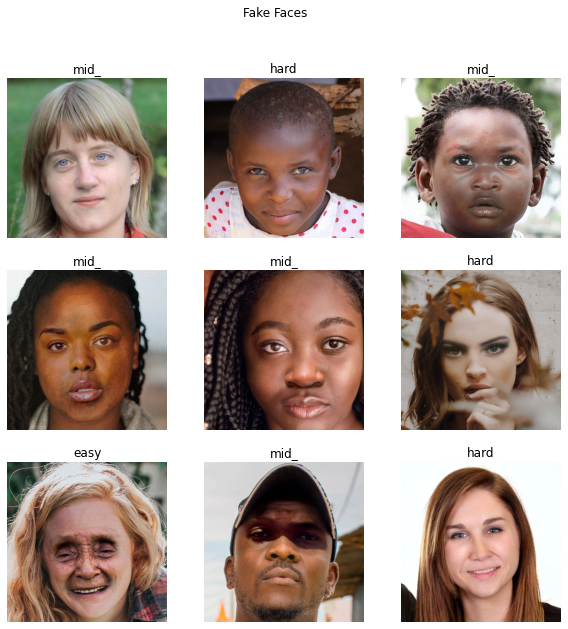

In [5]:
plot_image(train_fake, 'Fake Faces').show()

# Preparing Training Set

In [6]:
path_data = '../input/real-and-fake-face-detection/real_and_fake_face/'
data_gen = ImageDataGenerator(rescale=1./255,
                              horizontal_flip=True,
                              zoom_range=0.2,
                              rotation_range=20,
                              shear_range=0.3,
                              width_shift_range=0.2,
                             )
training_set = data_gen.flow_from_directory(path_data,
                                            class_mode='binary',
                                            shuffle=True,
                                            target_size=(96,96),
                                            batch_size=64,
                                           )

training_set.class_indices

Found 2041 images belonging to 2 classes.


{'training_fake': 0, 'training_real': 1}

# Creating Model Architecture

In [7]:

mobilenet = MobileNetV2(input_shape=(96, 96, 3),
                        include_top=False,
                        weights='imagenet'
                       )
model = tf.keras.models.Sequential([mobilenet,
                                    GlobalAveragePooling2D(),
                                    Dense(512, activation='relu'),
                                    BatchNormalization(),
                                    Dropout(0.3),
                                    Dense(1, activation='sigmoid')
                                   ])
model.compile(optimizer=Adam(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy']
             )
model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 2,916,417
Trainable params: 2,881,281
Non-tra

In [8]:
hist = model.fit(x=training_set, epochs=20)

Epoch 1/20
32/32 [==============================] - 36s 1s/step - loss: 1.0916 - accuracy: 0.5478
Epoch 2/20
32/32 [==============================] - 26s 816ms/step - loss: 0.7889 - accuracy: 0.6066
Epoch 3/20
32/32 [==============================] - 26s 809ms/step - loss: 0.6763 - accuracy: 0.6443
Epoch 4/20
32/32 [==============================] - 26s 803ms/step - loss: 0.6267 - accuracy: 0.6933
Epoch 5/20
32/32 [==============================] - 26s 798ms/step - loss: 0.5946 - accuracy: 0.7104
Epoch 6/20
32/32 [==============================] - 26s 816ms/step - loss: 0.5517 - accuracy: 0.7335
Epoch 7/20
32/32 [==============================] - 26s 819ms/step - loss: 0.5131 - accuracy: 0.7423
Epoch 8/20
32/32 [==============================] - 26s 808ms/step - loss: 0.4607 - accuracy: 0.7795
Epoch 9/20
32/32 [==============================] - 26s 821ms/step - loss: 0.4297 - accuracy: 0.8060
Epoch 10/20
32/32 [==============================] - 26s 800ms/step - loss: 0.3943 - accuracy:

# Accuracy and Loss Graph

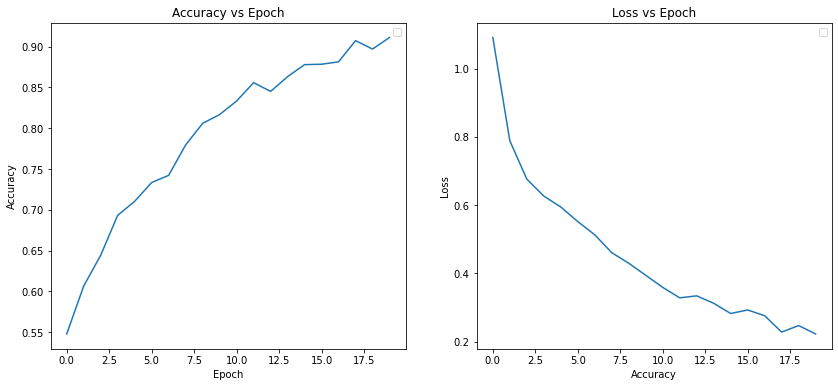

In [9]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'])
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'])
plt.title('Loss vs Epoch')
plt.xlabel('Accuracy')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Confusion Matrix and Classification Report

In [10]:
y_pred = model.predict(training_set)
y_pred = (y_pred < 0.5).astype(np.int)

from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)

print('Classification Report')
print(classification_report(training_set.classes, y_pred, target_names=['fake', 'real']))


Confusion Matrix
[[880  80]
 [970 111]]
Classification Report
              precision    recall  f1-score   support

        fake       0.48      0.92      0.63       960
        real       0.58      0.10      0.17      1081

    accuracy                           0.49      2041
   macro avg       0.53      0.51      0.40      2041
weighted avg       0.53      0.49      0.39      2041



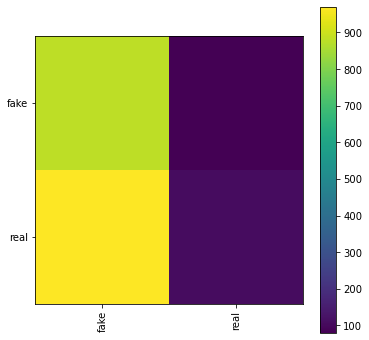

In [11]:
plt.figure(figsize=(6,6))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
target_names = ['fake', 'real']
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, ['fake', 'real'], rotation=90)
_ = plt.yticks(tick_mark, ['fake', 'real'])

In [12]:
model.save('mobilenet.h5')